# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import requests
from sklearn.utils import shuffle

import tensorflow as tf
import keras
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import requests
import xml.etree.ElementTree as ET
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Creating Dataset

In [ ]:
def fetch_fasta_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Failed to retrieve data: {response.status_code}")
        return None

def parse_fasta(data):
    protein_ids = []
    for line in data.split('\n'):
        if line.startswith('>'):
            # extract the protein ID from the header 
            protein_id = line.split('|')[1]  
            protein_ids.append(protein_id)
    return protein_ids

url = 'https://rest.uniprot.org/uniprotkb/stream?format=fasta&query=%28organism_id%3A9606%29+AND+%28reviewed%3Atrue%29+AND+%28proteins_with%3A27%29+AND+%28proteins_with%3A7%29+AND+%28proteins_with%3A57%29'
fasta_data = fetch_fasta_data(url)

if fasta_data:
    protein_ids = parse_fasta(fasta_data)
    print(protein_ids)


In [ ]:
protein_ids_1000 = protein_ids[:1000]


In [ ]:
def get_primary_structure(uniprot_id):
    url_sequence = f'https://www.uniprot.org/uniprot/{uniprot_id}.fasta'
    fasta_data = requests.get(url_sequence).text
    sequence_lines = fasta_data.split('\n')[1:]  # get only the sequence
    sequence = ''.join(sequence_lines)
    return sequence

def get_secondary_structure(uniprot_id):
    url_xml = f'https://www.uniprot.org/uniprot/{uniprot_id}.xml'
    xml_data = requests.get(url_xml).text
    i = ET.fromstring(xml_data)

    
    secondary_structure_annotations = []
    for feature in i.findall('.//{http://uniprot.org/uniprot}feature'):
        feature_type = feature.attrib.get('type', '')
        if feature_type in ['helix', 'strand', 'turn']:
            location = feature.find('{http://uniprot.org/uniprot}location')
            start = int(location.find('{http://uniprot.org/uniprot}begin').attrib['position'])
            end = int(location.find('{http://uniprot.org/uniprot}end').attrib['position'])
            if feature_type == 'helix':
                secondary_structure_annotations.extend(['H'] * (end - start + 1))
            elif feature_type == 'strand':
                secondary_structure_annotations.extend(['B'] * (end - start + 1))
            elif feature_type == 'turn':
                secondary_structure_annotations.extend(['T'] * (end - start + 1))

    return ''.join(secondary_structure_annotations)

In [ ]:
prot_primary_seq = []

In [ ]:
prot_primary_seq = []
for i in protein_ids_1000:
    a = get_primary_structure(i)
    prot_primary_seq.append(a)
prot_primary_seq

In [ ]:
prot_secondary_seq = []

In [ ]:
prot_secondary_seq = []
for i in protein_ids_1000:
    b = get_secondary_structure(i)
    prot_secondary_seq.append(b)
prot_secondary_seq

In [6]:
df = pd.read_csv('../Final/data.csv')
prot_primary_seq = df.iloc[:, 0].tolist()


prot_secondary_seq = df.iloc[:, 1].tolist()


3000

# Encoding and padding

In [7]:
properties_dict =  {
    'A': [1.28, 0.05, 1.00, 0.31, 6.11, 0.42, 0.23], # [streric parameter, polarizability,volume,hydrophobicity,isoelectric point,H prob.,B prob.]
    'G': [0.00, 0.00, 0.00, 0.00, 6.07, 0.13, 0.15],
    'V': [3.67, 0.14, 3.00, 1.22, 6.02, 0.27, 0.49],
    'L': [2.59, 0.19, 4.00, 1.70, 6.04, 0.39, 0.31],
    'I': [4.19, 0.19, 4.00, 1.80, 6.04, 0.30, 0.45],
    'F': [2.94, 0.29, 5.89, 1.79, 5.67, 0.30, 0.38],
    'Y': [2.94, 0.30, 6.47, 0.96, 5.66, 0.25, 0.41],
    'W': [3.21, 0.41, 8.08, 2.25, 5.94, 0.32, 0.42],
    'T': [3.03, 0.11, 2.60, 0.26, 5.60, 0.21, 0.36],
    'S': [1.31, 0.06, 1.60, -0.04, 5.70, 0.20, 0.28],
    'R': [2.34, 0.29, 6.13, -1.01, 10.74, 0.36, 0.25],
    'K': [1.89, 0.22, 4.77, -0.99, 9.99, 0.32, 0.27],
    'H': [2.99, 0.23, 4.66, 0.13, 7.69, 0.27, 0.30],
    'D': [1.60, 0.11, 2.78, -0.77, 2.95, 0.25, 0.20],
    'E': [1.56, 0.15, 3.78, -0.64, 3.09, 0.42, 0.21],
    'N': [1.60, 0.13, 2.95, -0.60, 6.52, 0.21, 0.22],
    'Q': [1.56, 0.18, 3.95, -0.22, 5.65, 0.36, 0.25],
    'M': [2.35, 0.22, 4.43, 1.23, 5.71, 0.38, 0.32],
    'P': [2.67, 0.00, 2.72, 0.72, 6.80, 0.13, 0.34],
    'C': [1.77, 0.13, 2.43, 1.54, 6.35, 0.17, 0.41]
}

def encode_with_properties(prot_primary_seq, properties_dict):
    encoded_seqs = []
    for sequence in prot_primary_seq:
        encoded_seq = []
        for aa in sequence:
            if aa in properties_dict:
                encoded_seq.append(properties_dict[aa])
            else:
                encoded_seq.append([0.0] * len(next(iter(properties_dict.values()))))  # Default to zeros if unknown
        encoded_seqs.append(encoded_seq)
    
    return (encoded_seqs)

def one_hot_encode2(prot_secondary_seq):
    encoded_seqs2 = []
    secondary_structure = ['H', 'B', 'T']  
    ss_to_index = {ss: i for i, ss in enumerate(secondary_structure)}
    
    for sequence in prot_secondary_seq:
        encoded_seq2 = np.zeros((len(sequence), len(secondary_structure)))
        
        # go over each secondary structure symbol in the sequence
        for i, ss in enumerate(sequence):
            if ss in ss_to_index:
                index = ss_to_index[ss]
                encoded_seq2[i, index] = 1
        
        encoded_seqs2.append(encoded_seq2)

    return encoded_seqs2


encoded_primary = encode_with_properties(prot_primary_seq, properties_dict)


encoded_secondary = one_hot_encode2(prot_secondary_seq)

#primary padding
max_length = max(len(seq) for seq in encoded_primary)
padded_primary_sequences = pad_sequences(encoded_primary, maxlen=max_length, padding='post',dtype='float32')

#secondary padding; keep the same lenght of encoded_primary so that it fits in the model

padded_secondary_sequences = pad_sequences(encoded_secondary, maxlen=max_length, padding='post')

print(padded_primary_sequences.shape)
print(padded_secondary_sequences.shape)


(3000, 6669, 7)
(3000, 6669, 3)


# Splitting Data and Model

In [8]:
X = padded_primary_sequences
y = padded_secondary_sequences


train_size = 0.7  # 70% of the data for training
val_size = 0.15   # 15% of the data for validation
test_size = 0.15  # 15% of the data for testing

# split the data into training, validation, and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=42)

#  verify the shapes of your sets
print("Training set shapes:", X_train.shape, y_train.shape)
print("Validation set shapes:", X_val.shape, y_val.shape)
print("Test set shapes:", X_test.shape, y_test.shape)

Training set shapes: (2099, 6669, 7) (2099, 6669, 3)
Validation set shapes: (451, 6669, 7) (451, 6669, 3)
Test set shapes: (450, 6669, 7) (450, 6669, 3)


In [10]:


# model1
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (max_length, 7)),  # input layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),  # BILSTM layer
    tf.keras.layers.Dropout(0.5),  # dropout layer
    tf.keras.layers.Dense(3, activation='softmax')  # output layer
 ])

# compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# training the model
modeling = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),  
                    epochs=10, 
                    batch_size=32)

 #evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1881s 28s/step - accuracy: 0.3570 - loss: 0.0435 - val_accuracy: 0.0154 - val_loss: 0.0374
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1768s 27s/step - accuracy: 0.3572 - loss: 0.0558 - val_accuracy: 0.9824 - val_loss: 0.0371
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1845s 28s/step - accuracy: 0.3606 - loss: 0.0562 - val_accuracy: 0.9826 - val_loss: 0.0356
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1558s 24s/step - accuracy: 0.3603 - loss: 0.0551 - val_accuracy: 0.9826 - val_loss: 0.0371
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1566s 24s/step - accuracy: 0.3591 - loss: 0.0556 - val_accuracy: 0.9829 - val_loss: 0.0368
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1542s 23s/step - accuracy: 0.3602 - loss: 0.0564 - val_accuracy: 0.9829 - val_loss: 0.0371
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1555s 24s/step - accuracy: 0.3590 - loss: 0.0549 - val_accuracy: 0.9830 - val_loss: 0.0370
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1530s 23s/step - accuracy: 0.3598 - loss: 0.0547 - val_accu

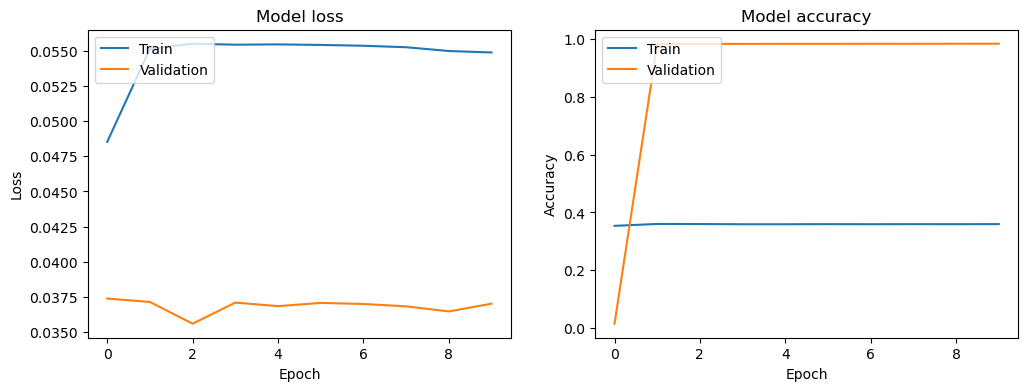

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(modeling.history['loss'])
plt.plot(modeling.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(modeling.history['accuracy'])
plt.plot(modeling.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
